# Защита персональных данных клиентов

## Цель 

Разработайть метод преобразования данных для компании «Хоть потоп»<br>
С целью защиты персональных данных её клиентов <br>
Что бы по ним было сложно восстановить персональную информацию<br>

Доказать корректность работы метода<br>
<br>
При этом:<br>
Качество модели на преобразованных данных должно соответствовать качеству модели на исходных данных<br>

## Описание данных

Набор данных находится в файле https://code.s3.yandex.net/datasets/insurance.csv
- Признаки: пол, возраст, зарплата застрахованного, количество членов его семьи
- Целевой признак: количество страховых выплат клиенту за последние 5 лет

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from scipy import stats as st
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, r2_score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.dummy import DummyRegressor

In [3]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%

In [4]:
try:
    import phik
    from phik.report import plot_correlation_matrix
    from phik import report
except:
    !pip install phik
    import phik
    from phik.report import plot_correlation_matrix
    from phik import report

In [5]:
try:
    data = pd.read_csv('insurance.csv')

except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/insurance.csv')
  

In [6]:
def isna_count_procent(data, name):
    isna_columns = data.isna().sum() > 0
    isna_columns = pd.DataFrame([data.isna().sum()[isna_columns]/data.shape[0], data.isna().sum()[isna_columns]]).T
    isna_columns = isna_columns.rename(columns={0: 'procent', 1: 'count'})
    isna_columns['count'] = isna_columns['count'].map('{:,.2f}'.format)
    isna_columns['procent'] = isna_columns['procent'].map('{:,.2%}'.format)
    isna_columns = isna_columns.sort_values('procent', ascending=False)
    # блок показывае всё о данных
    display(data.head(5))
    print('#'*55)
    print()
    display(data.describe())
    print('#'*55)
    print()
    data.info()
    print('#'*55)
    isna = data.isna().sum().sum()
    isna_procent = isna/data.shape[0]
    print()
    print(f'Всего пропусков в {name} {isna} шт. в {len(isna_columns)} столбцах')
    print(f'В процентном отношении {isna_procent:.2%} шт. от {data.shape[0]} длинны')
    print()
    s = data.duplicated().sum()
    print(f'Количество дубликатов в данных  равно {s}')

    return isna_columns, pd.set_option('display.max_rows', None)

In [7]:
isna_count_procent(data, 'insurance.csv')

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


#######################################################



,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


#######################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB
#######################################################

Всего пропусков в insurance.csv 0 шт. в 0 столбцах
В процентном отношении 0.00% шт. от 5000 длинны

Количество дубликатов в данных  равно 153


(Empty DataFrame
 Columns: [procent, count]
 Index: [],
 None)

In [8]:
# удалим дубоикаты в данных
data = data.drop_duplicates().reset_index(drop=True)

s = data.duplicated().sum()
print(f'Количество дубликатов в данных  равно {s}')
print(f'Количество строк insurance.csv после удаления дубликатов {data.shape[0]}')

Количество дубликатов в данных  равно 0
Количество строк insurance.csv после удаления дубликатов 4847


In [9]:
# поправим названия признаков 
data.columns = data.columns.str.lower() 
data = data.rename(columns={'члены семьи': 'члены_семьи', 'страховые выплаты': 'страховые_выплаты'})
data['возраст'] = data['возраст'].astype(int)

Познакомились с данными, удалили дубликаты в строках<br>
Пропуски отсутствуют<br>
В данных 5 столбцов все в числовом формате<br>
Признак `пол` закодирован в нули и единицы, это единственный категориальный признак<br>
Привели названия признаков к нижнему регистру<br>
Признак `возраст` поменяли тип на целочисленный<br>

In [10]:
# функция гистограммы данных 
def data_hist(data, name_data):
    fig, (ax, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(25, 2))
    fig.text(0.45, 0.95, f'Гистограммы {name_data}', size='x-large', weight='bold')

    sns.histplot(data = data['пол'], edgecolor='black', bins=40, linewidth=1, ax=ax)
    sns.histplot(data = data['возраст'], edgecolor='black', bins=40, linewidth=1, ax=ax1)
    sns.histplot(data = data['зарплата'], edgecolor='black', bins=30, linewidth=1, ax=ax2)
    sns.histplot(data = data['члены_семьи'], edgecolor='black', bins=40, linewidth=1, ax=ax3)
    sns.histplot(data = data['страховые_выплаты'], edgecolor='black', bins=40, linewidth=1, ax=ax4)
    
    plt.show()

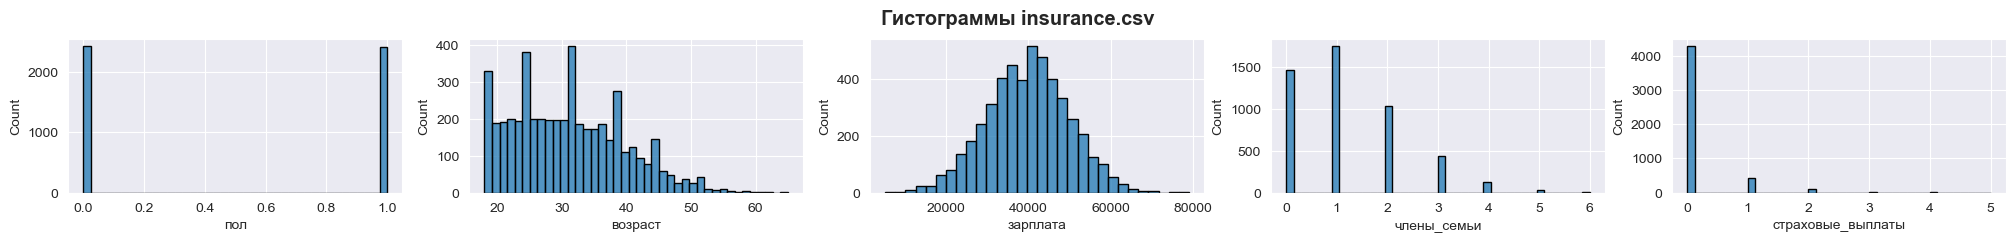

In [11]:
# построим гистограммы наших данных
data_hist(data, 'insurance.csv')

Данные распределены согласованно с логикой<br>
В признаке `возраст` присутствуют всплески <br>
У признака `зарплата` распределение нормальное<br>

In [12]:
def corr_psk(data): 
    fig, (ax, ax1, ax2, ax3 ) = plt.subplots(1, 4, figsize=(35, 4))

    sns.heatmap(data = data.corr(), annot=True, ax=ax).set_title('Корреляция Пирсона', weight='bold', size='large');
    sns.heatmap(data = data.corr(method = 'spearman'), annot=True, ax=ax1).set_title('Корреляция Спирмена', weight='bold', size='large');
    sns.heatmap(data = data.corr(method = 'kendall'), annot=True, ax=ax2).set_title('Корреляция Кенделла', weight='bold', size='large');
    sns.heatmap(data = data.phik_matrix(interval_cols=data.columns), annot=True, ax=ax3).set_title('Корреляция $\phi_K$', weight='bold', size='large');
    
    plt.show()

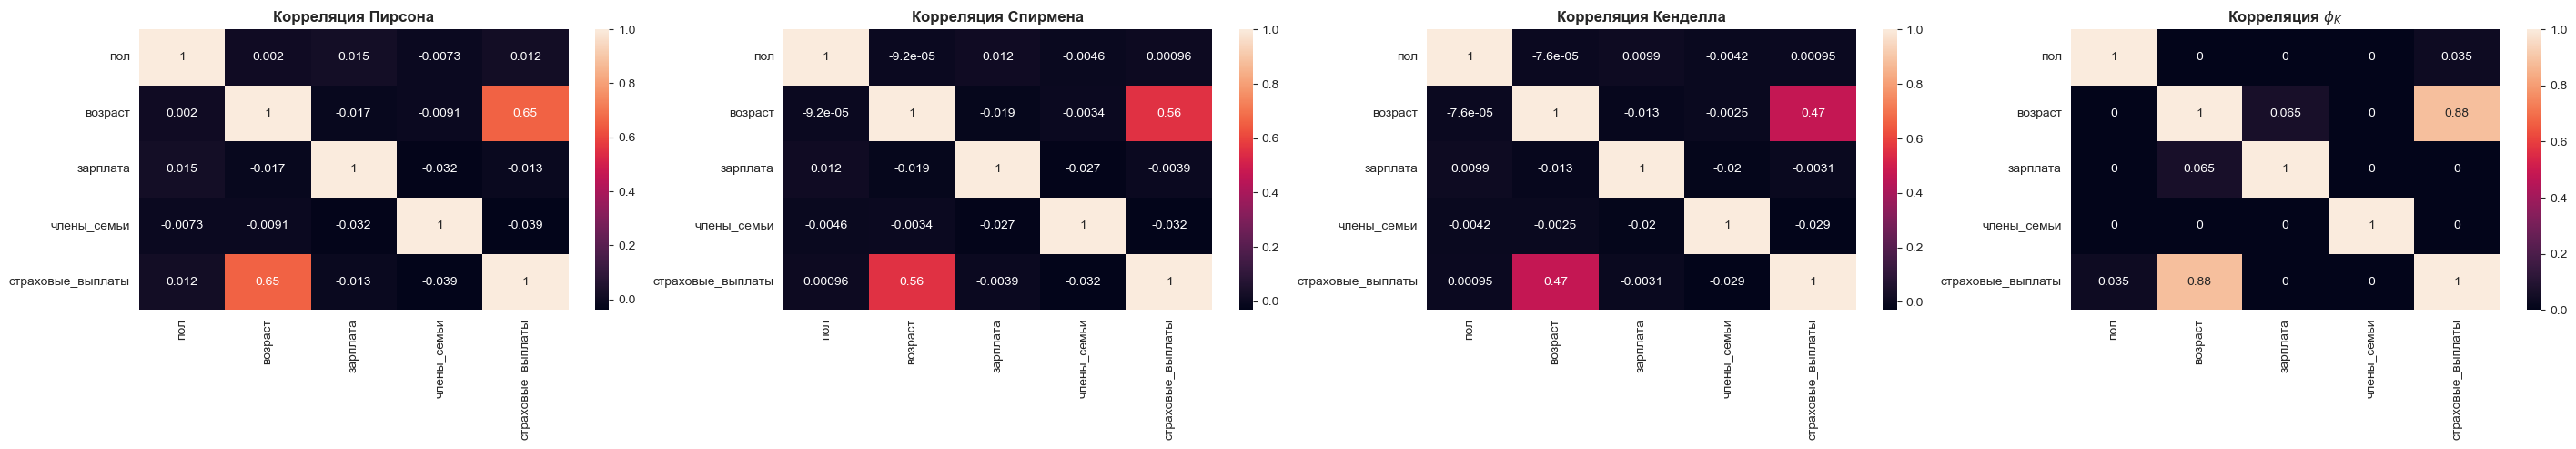

In [13]:
corr_psk(data)

На всех тепловых картах мультиколлинеарность признаков отсутствует<br>
С целевым признаком корреляция у признака `возраст` в диапазоне слабая-средняя<br>
У категориального признака `пол` очень слабая корреляция с целевым признаком<br>

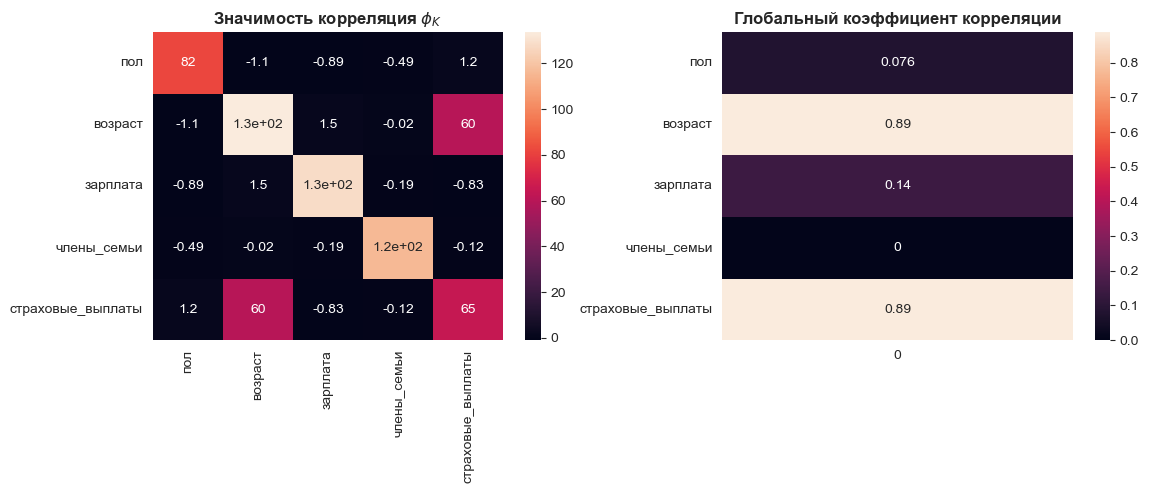

In [14]:
fig, (ax, ax1 ) = plt.subplots(1, 2, figsize=(13, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
significance_overview = data.significance_matrix(interval_cols=data.columns)
sns.heatmap(data = significance_overview.round(2), annot=True, ax=ax).set_title('Значимость корреляция $\phi_K$', weight='bold', size='large');
global_labels = data.global_phik(interval_cols=data.columns)
sns.heatmap(data=global_labels[0], yticklabels=global_labels[1], annot=True, ax=ax1).set_title('Глобальный коэффициент корреляции', weight='bold', size='large');

Значимость корреляции относительно целевого признака подтверждает признак `возраст`<br>
Категориальный признак имеет ничтожную значимость, а признак `члены семьи` почти нулевую <br>
У признака `члены семьи` нулевой глобальный коэффициент корреляции<br>

In [15]:
# посмотрим выбросы
def mustache_box(data, name):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    sns.boxplot(data=data, orient='h').set_title(name, weight='bold', size='large');
    plt.show()

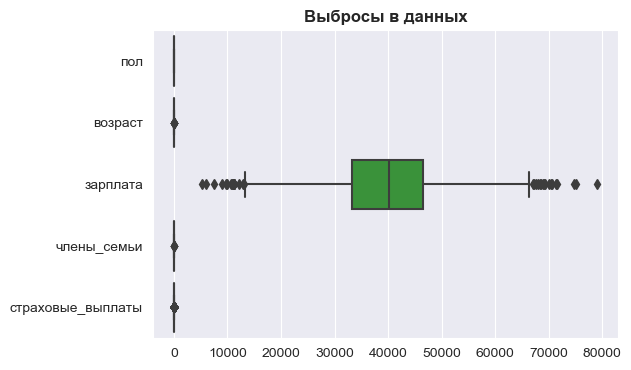

In [16]:
mustache_box(data=data, name='Выбросы в данных')

In [17]:
# функция размаха ящика с усами
def cut_crap(data, features):
    for features in features:
        q1 = np.percentile(data[features], 25)
        q3 = np.percentile(data[features], 75)
        min_ = q1-(1.5*(q3-q1))
        max_ = q3+(1.5*(q3-q1))
        data = data.loc[(data[features] > min_) & (data[features] < max_)]
    return data

In [18]:
# отфильтруем признаки от выбрасов по ящику с усами
list_features = ['пол', 'возраст', 'зарплата', 'члены_семьи']
data = cut_crap(data=data, features=list_features)

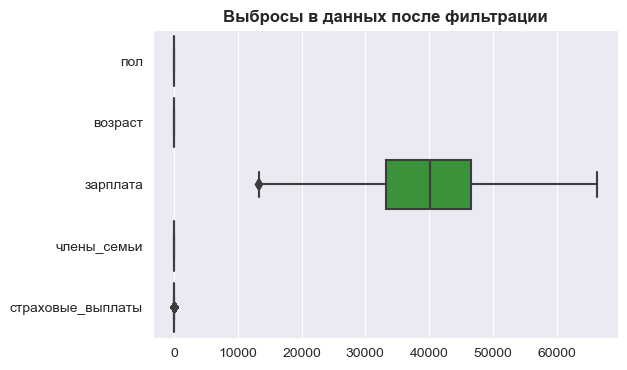

In [19]:
mustache_box(data=data, name='Выбросы в данных после фильтрации')

Отфильтровали данные от выбрасов

### Вывод

Познакомились с данными, удалили дубликаты в строках <br> 
Пропуски отсутствуют<br> 
В данных 5 столбцов все в числовом формате<br> 
Признак пол закодирован в нули и единицы, это единственный категориальный признак<br> 
Привели названия признаков к нижнему регистру<br> 
Признак возраст поменяли тип на целочисленный<br> 
<br> 
Данные распределены согласованно с логикой<br> 
В признаке возраст присутствуют всплески<br> 
У признака зарплата распределение нормальное<br> 
<br> 
На тепловых картах корреляции мультиколлинеарность признаков отсутствует<br> 
С целевым признаком корреляция у признака `возраст` в диапазоне слабая-средняя<br> 
У категориального признака  `пол` очень слабая корреляция с целевым признаком<br> 
<br> 
Значимость корреляции относительно целевого признака присутствует у признака `возраст`<br> 
Категориальный признак `пол` имеет ничтожную значимость, а признак `члены семьи` почти нулевую<br> 
У признака `члены семьи` нулевой глобальный коэффициент корреляции<br> 
<br> 
Удалили выбросы в целевых признаках, размер данных составил 4762 строки | 5 столбцов<br> 


In [20]:
features = data.drop(columns='страховые_выплаты', axis=1)
target = data['страховые_выплаты']

In [21]:
model_lr = LinearRegression()
model_lr.fit(features, target);
predict_lr = model_lr.predict(features)

In [22]:
angle_coefficients = pd.DataFrame([model_lr.coef_.round(5)], columns=list_features)
angle_coefficients['intercept'] = model_lr.intercept_
angle_coefficients

,пол,возраст,зарплата,члены_семьи,intercept
0,0.00547,0.03358,0.0,-0.01402,-0.887187


Коэффициент признака `зарплата` определяется в нуле поэтому его полезность ничему не равна и мы могли бы его удалить<br>
Нашей задачей является преобразовать данные таким образом, чтобы качество модели до преобразования и после сохранилось<br>
По этому оставим все признаки как есть <br>

In [23]:
exam_lr = pd.concat([pd.DataFrame(predict_lr, columns=['predict']), target], axis=1)


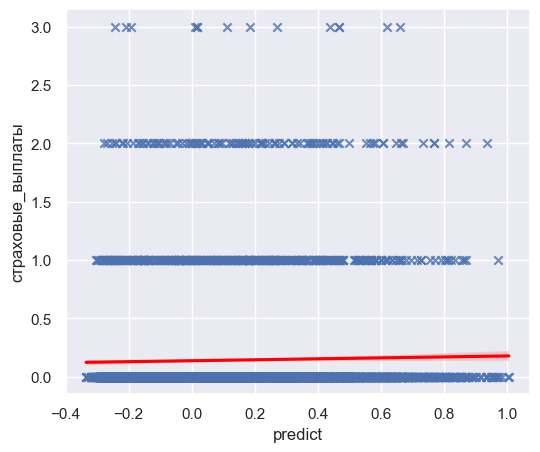

In [24]:
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.regplot(data=exam_lr, x='predict', y='страховые_выплаты', ax=ax, line_kws={'color':'red'}, marker='x')
ax1.set_title('data_0', weight='bold', size='large')

plt.show()

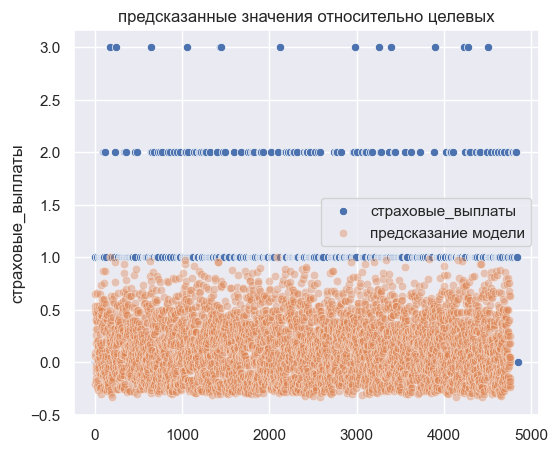

In [25]:
# посторим график на котором сравним исходные таргеты и предсказания моделей
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.scatterplot(data=exam_lr['страховые_выплаты'], ax=ax, ) \
    .set_title('предсказанные значения относительно целевых');
sns.scatterplot(data=exam_lr['predict'], ax=ax, alpha=0.4);

ax.legend(['страховые_выплаты', 'предсказание модели'])

plt.show()

In [26]:
model_logr = LogisticRegression(C=1e5)
model_logr.fit(features, target);
predict_logr = model_logr.predict(features)

In [27]:
exam_logr = pd.concat([pd.DataFrame(predict_logr, columns=['predict']), target], axis=1)

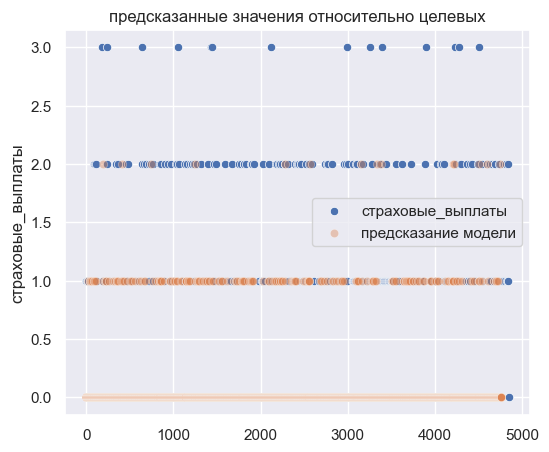

In [28]:
# посторим график на котором сравним исходные таргеты и предсказания моделей
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.scatterplot(data=exam_logr['страховые_выплаты'], ax=ax ) \
    .set_title('предсказанные значения относительно целевых');
sns.scatterplot(data=exam_logr['predict'], ax=ax, alpha=0.4);

ax.legend(['страховые_выплаты', 'предсказание модели'])

plt.show()

In [29]:
exam_logr['predict'].value_counts()

0.0    4550
1.0     198
2.0      14
Name: predict, dtype: int64

## Умножение матриц

Вопрос на который мы хотим ответить:<br>
Изменится ли качество модели предсказания линейной регрессии до и после преобразования?

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $M$ — квадратная матрица $det  ≠ 0  $ на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

- $E$ - единичная матрица

- $ M^{-1}$ - обратная матрица 

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Для разработки метода по защите данных будем использовать свойство матриц<br>
Нам известно, что любая матрица умноженная на единичную матрицу если их произведение определено – равна самой себе<br>
Так же мы знаем, что любая квадратная матрица чей *определитель* отличен от нуля умноженная на обратную к себе матрицу<br>
Как слева так и справа равно единичной матрице <br>
$$
M  M^{-1} =M^{-1} M = E
$$
Важным свойством умножения матриц является свойство ассоциативности <br>
$$
X(MC) = (XM)C
$$
Для преобразования мы будем умножать признаки наших данных и коэффициеты на обратимую квадратную матрицу<br>
$$
a = (XM)(wM)
$$
Для преобразования обратно умножим на обратную матрицу

$$
a = X(MM^{-1})w(MM^{-1})
$$ 

Как нам известно если квадратную матрицу умножить на обратную ей матрицу результатом будет единичная матрица <br>
Подставим в нашу формулу
$$
a = XEwE
$$
Матрица умноженная на единичную равна самой себе сократим $E$ матрицу в нашей формуле

$$
a = Xw
$$

Таким образом мы получили исходную формулу предсказания модели

**Ответ:** Качество модели линейной регрессии не изменится после преобразования матрицы признаков <br>
Путём умножения на обратимую квадратную матрицу<br>

**Обоснование:** Предсказания модели есть не что иное, как поиск наилучших коэффициентов для признаков<br>
Оптимальные коэффициенты задают лучший угол и высоту восстановленной линейной зависимости минимизируя <br>
Сумму квадратной разности ошибки между истинным значением и предсказанным<br>
А коэффициенты находятся из матрицы признаков умноженных на целевое значение по формуле
$$
w = (X^T X)^{-1} X^T y
$$
Получается, что преобразованная матрица и выраженные из неё коэффициенты в равной степени изменяются<br>
По этому качество модели линейной регрессии до и после преобразования одинаковое<br>

квадратная матрица $ M $ размера $ m=n  $<br>


$w' = ((XM)^T XM)^{-1} (XM)^T y$   <br>

$w' = (M^T X^T XM)^{-1} M^T X^T y$<br>

$ w' = M^{-1} (X^T X)^{-1} (M^T)^{-1} M^T X^T y  $<br>

$ E = (M^T)^{-1} M^T$<br>

$ w' = M^{-1} (X^T X)^{-1} X^T y$<br>

$w' = M^{-1} w$<br>

## Алгоритм преобразования

**Алгоритм**

...

**Обоснование**

...

## Проверка алгоритма

In [30]:
np.random.seed(1234)
features = np.concatenate((np.ones((features.shape[0], 1)), features), axis=1)

In [31]:
features.shape

square_matrix = np.random.normal(-20, 20, (features.shape[1], features.shape[1]))
square_matrix


array([[-10.57129673, -43.81951389,   8.65413937, -26.25303792,
        -34.41177467],
       [ -2.25674119,  -2.80823173, -32.73047009, -19.68607256,
        -64.85369908],
       [  3.00071449,  -0.16107955,  -0.93351744, -60.4250964 ,
        -26.68154732],
       [-19.95763271, -11.89093177, -14.21816118,   6.42316384,
        -50.93811106],
       [-24.05292649, -33.11938688, -16.13157247,  -8.93122178,
          6.36303108]])

In [32]:
square_matrix.shape

(5, 5)

In [33]:
ser = features.dot(square_matrix)
ser.shape
# ser = np.abs(np.linalg.inv(square_matrix.dot(ser.T)))
ecoded_features = abs(ser.dot(np.linalg.inv(square_matrix)))

In [34]:
np.array_equal (features, ecoded_features)
np.allclose (features, ecoded_features, atol= 1 )

True

## Чек-лист проверки

In [35]:
list_features.insert(0, 'смещение')
list_features

['смещение', 'пол', 'возраст', 'зарплата', 'члены_семьи']

In [36]:
featuresrt = pd.DataFrame(features).describe()


In [37]:
featuresrt

,0,1,2,3,4
count,4762.0,4762.000000,4762.000000,4762.000000,4762.000000
mean,1.0,0.497690,30.947291,39924.338513,1.171777
std,0.0,0.500047,8.377962,9670.933473,1.042218
min,1.0,0.000000,18.000000,13200.000000,0.000000
25%,1.0,0.000000,24.000000,33300.000000,0.000000
50%,1.0,0.000000,30.000000,40200.000000,1.000000
75%,1.0,1.000000,37.000000,46600.000000,2.000000
max,1.0,1.000000,56.000000,66300.000000,4.000000


In [38]:
ecoded_featuresre = pd.DataFrame(ecoded_features).describe().round(6)
ecoded_featuresre

,0,1,2,3,4
count,4762.0,4762.000000,4762.000000,4762.000000,4762.000000
mean,1.0,0.497690,30.947291,39924.338513,1.171777
std,0.0,0.500047,8.377962,9670.933473,1.042218
min,1.0,0.000000,18.000000,13200.000000,0.000000
25%,1.0,0.000000,24.000000,33300.000000,0.000000
50%,1.0,0.000000,30.000000,40200.000000,1.000000
75%,1.0,1.000000,37.000000,46600.000000,2.000000
max,1.0,1.000000,56.000000,66300.000000,4.000000


In [39]:
ecoded_featuresre == featuresrt

,0,1,2,3,4
count,True,True,True,True,True
mean,True,False,False,False,False
std,True,False,False,False,False
min,True,True,True,True,True
25%,True,True,True,True,True
50%,True,True,True,True,True
75%,True,True,True,True,True
max,True,True,True,True,True


Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные загружены
- [ ]  Выполнен шаг 2: получен ответ на вопрос об умножении матриц
    - [ ]  Указан правильный вариант ответа
    - [ ]  Вариант обоснован
- [ ]  Выполнен шаг 3: предложен алгоритм преобразования
    - [ ]  Алгоритм описан
    - [ ]  Алгоритм обоснован
- [ ]  Выполнен шаг 4: алгоритм проверен
    - [ ]  Алгоритм реализован
    - [ ]  Проведено сравнение качества моделей до и после преобразования